# Variational Quantum Linear Solver (VQLS)

___

The **Variational Quantum Linear Solver (VQLS)** is a hybrid quantum–classical algorithm designed to solve linear systems of equations of the form:

$$
A \cdot x = b
$$

where:

- $A$ is the matrix of interest
- $b$ is the known vector  
- $x$ is the solution vector we want to obtain 

___





## VQLS in action

For purpose of this tutorial we would be working with $A$ matrix representing an Ising model. This is a simple toy model and might not have any practical use-case. 

Let us start with importing all the necessary modules. 

In [1]:
import math
import random
from collections import Counter
from typing import Dict, List, Tuple
import warnings

import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Operator, SparsePauliOp, Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit.primitives import Estimator, Sampler
from qiskit_aer import Aer
from qiskit_algorithms import optimizers as opt
from scipy.linalg import solve as sp_solve
from scipy.optimize import minimize
from scipy.sparse import csr_matrix, identity, kron

# Local package imports
from vqls_prototype.matrix_decomposition.matrix_decomposition import PauliDecomposition
from vqls_prototype.solver.vqls import VQLS
from vqls_prototype.visualize import *
from qiskit.visualization import circuit_drawer


## Decomposing $A$ as a LCU

To run VQLS on a quantum computer, the matrix $A$ must be expressed as a linear combination of unitary (LCU) matrices:

$$
A = \sum_{l} c_l A_l
$$

where each $A_l$ is a unitary operator and $c_l$ are complex coefficients.

This decomposition enables efficient evaluation of matrix–vector products on quantum hardware.

In [2]:

# Problem parameters
N = 2 # Number of grid points in one dimension

#Ising matrix construction

ising_matrix = construct_ising_matrix(N, J=0.5, eta=1.0)# matrix is 2^N x 2^N
"""
The matrix is of the form:
        A = X_term + J * ZZ_term + eta * I

    - `X_term` (transverse field): sum_j (I ⊗ ... ⊗ X_j ⊗ ... ⊗ I)
      (each site has a Pauli-X acting on that qubit)
    - `ZZ_term` (interaction): sum_j (I ⊗ ... ⊗ Z_j Z_{j+1} ⊗ ... ⊗ I)
      (nearest-neighbour Z–Z interactions)
    - `eta * I` : identity term scaled by `eta` (a diagonal shift)
"""

print("Ising Matrix:")
print(ising_matrix)

A = ising_matrix

Ising Matrix:
[[0.48994745 0.32663163 0.32663163 0.        ]
 [0.32663163 0.16331582 0.         0.32663163]
 [0.32663163 0.         0.16331582 0.32663163]
 [0.         0.32663163 0.32663163 0.48994745]]


In [3]:
# Create a PauliDecomposition object for matrix A

pauli_decomposer = PauliDecomposition(matrix=A)

coeffs, _, circuits = pauli_decomposer.decompose_matrix()
pauli_strings = pauli_decomposer.strings

print(pauli_decomposer._create_circuit)

100%|██████████| 16/16 [00:00<00:00, 3305.53it/s]

<function PauliDecomposition._create_circuit at 0x11981f740>


In [4]:
print("\n=== Pauli Decomposition Results ===")
for c, s in zip(coeffs, pauli_strings):
    print(f"{s}: {c}")


=== Pauli Decomposition Results ===
II: (0.3266316347104093+0j)
IX: (0.3266316347104093+0j)
XI: (0.3266316347104093+0j)
ZZ: (0.16331581735520467+0j)


In [5]:
# Function to print the full Pauli decomposition of the matrix
def print_pauli_equation(coeffs, strings):
    terms = []
    for c, p in zip(coeffs, strings):
        # Remove tiny imaginary parts
        if abs(c.imag) < 1e-12:
            c = c.real
        terms.append(f"({c})*{p}")
    print("\nA = " + " + ".join(terms))

print_pauli_equation(coeffs, pauli_strings)


A = (0.3266316347104093)*II + (0.3266316347104093)*IX + (0.3266316347104093)*XI + (0.16331581735520467)*ZZ


This is how the matrix $A$ is decomposed as a LCU. In particular the LCU's here are tensor products of Pauli matrices.

___

## Variational Ansatz

VQLS prepares a **parameterized quantum state** (ansatz):

$$
|x(\theta)\rangle = V(\theta) |0\rangle
$$

where:

- $V(\theta)$ is a parameterized quantum circuit  
- $\theta$ is a vector of tunable parameters optimized classically  

We will use a hardware efficient ansatz.

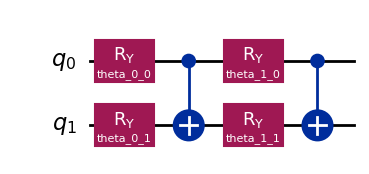

In [6]:
V = hardware_efficient_ansatz_param(N, layers=2)

from qiskit.visualization import circuit_drawer
circuit_drawer(V, output='mpl', filename='variational_circuit.png')

___


## Encoding the Vector $\ket{b}$

The known vector $b$ is encoded using a unitary $U$:

$$
|b\rangle = U |0\rangle
$$

For this tutorial we assume that $b$ is an equal superposition state. For any other normalized $\ket{b}$ one can use qiskit's `StatePreparation` function. 

In [7]:
b_vector = np.ones(2**N) / np.sqrt(2**N) # Uniform superposition state

# the above b_vector can be prepared by applying Hadamard gates to all qubits starting from |0...0>
U = QuantumCircuit(N)
for i in range(N):
    U.h(i)

___

## Cost Function

The goal of VQLS is to produce an ansatz state $|x(\theta)\rangle$ whose image under $A$ is aligned with the target vector $|b\rangle$.  


This is achieved by minimizing the cost function:

$$
C(\theta) = 
\langle x(\theta) | 
A^\dagger (\mathbb{I} - |b\rangle\langle b|) A 
| x(\theta) \rangle
$$


We have seen from the tutorial that this cost can also be written as,

$$C_G(\theta)=1-\frac{\sum_{\ell,\ell'} c_\ell c_{\ell'}^* \gamma_{\ell\ell'}(\theta)}
        {\sum_{\ell,\ell'} c_\ell c_{\ell'}^* \beta_{\ell\ell'}(\theta)}$$

where 
$$ \beta_{\ell\ell'} = \bra{0} V^\dagger A_{\ell'}^\dagger A_\ell V \ket{0} $$
$$ \gamma_{\ell\ell'} = 
\bra{0} U^\dagger A_\ell V\ket{0}\,
\bra{0} V^\dagger A_{\ell'}^\dagger U\ket{0}
$$

The $\beta$ and $\gamma$ coefficients are evaluated through Hadamard tests, which are usually low depth quantum circuits.

#### Hadmard Test to calculate Cost Function

Let's start with a specific set of terms from the decomposition above to build our intuition on computing $\beta$ and $\gamma$ coefficients.

In [8]:
# Pauli strings
Al  = pauli_strings[2]  
Alp = pauli_strings[3]  

print("The A_l and A_l' terms:", Al, Alp)

The A_l and A_l' terms: XI ZZ


#### Let's now visualize the quantum circuit to compute $\beta$ for the above Pauli terms

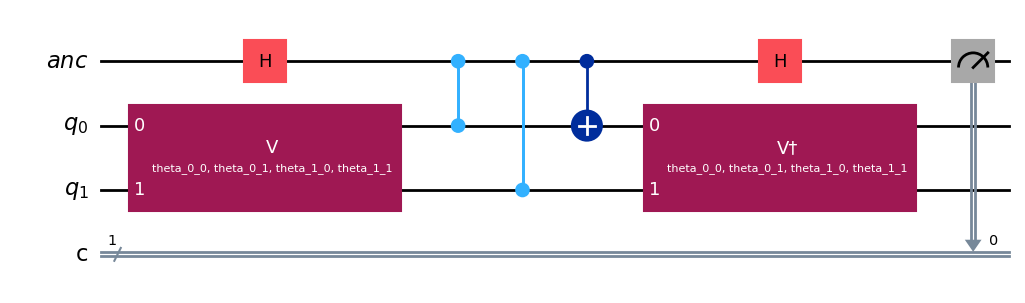

In [9]:
qc_beta  = hadamard_test_beta(V, Al, Alp)

#Visualise Hadmard test circuit for beta
circuit_drawer(qc_beta, output='mpl', filename='beta_circuit.png')

#### Let's now visualize the two quantum circuits to compute $\gamma$ for the above Pauli terms

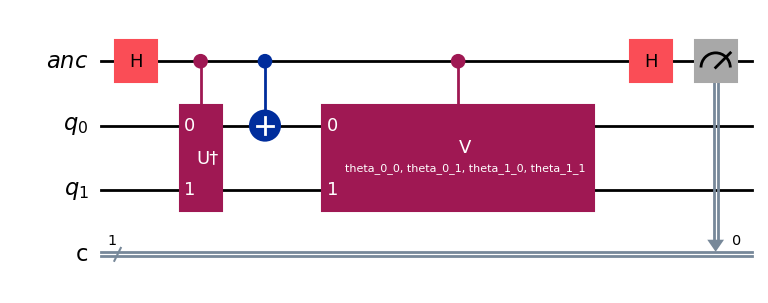

In [10]:
# circuit for gamma term with Al
qc_gamma_term = hadamard_test_gamma_Al(V, U, Al) 

#Visualise Hadmard test circuit for gamma
circuit_drawer(qc_gamma_term, output='mpl', filename='gamma_circuit.png')

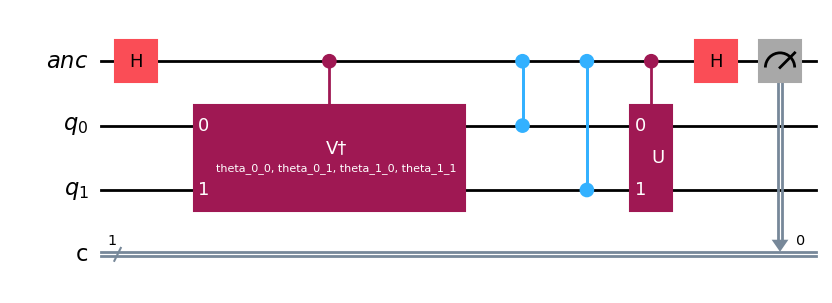

In [11]:
# circuit for gamma term with Al
qc_gamma_term = hadamard_test_gamma_Alp(V, U, Alp) 

#Visualise Hadmard test circuit for gamma
circuit_drawer(qc_gamma_term, output='mpl', filename='gamma_circuit_prime.png')

##### Using the circuits above for every Pauli term in the decomposition, we can compute the cost value for every iteration of the cost function optimization.
___

## Classical optimization

When the cost is minimized at the optimal angle parameters $\mathbf{\theta^*}$, the ansatz is proportional to the solution vector:

$$
x \propto |x(\theta^*)\rangle
$$

We instantiate the `VQLS` class which has the complete end to end implementation of the VQLS algorithm.For this tutorial we use COBYLA optimizer which is a gradient-free optimzer. 

100%|██████████| 16/16 [00:00<00:00, 4346.99it/s]

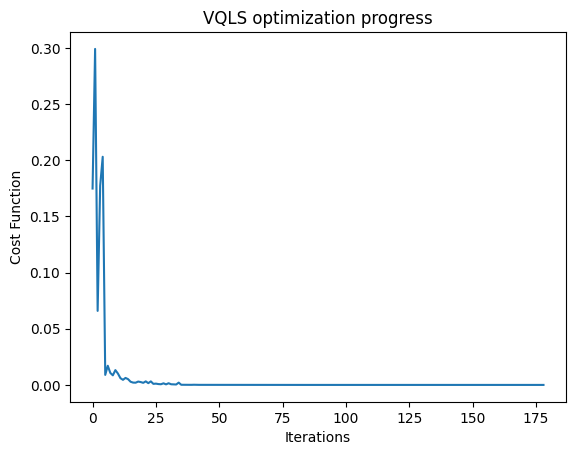

In [12]:
# Set up quantum primitives
backend = Aer.get_backend("statevector_simulator") # to simulate the statevector corresponding to the optimal angle parameters 
estimator = Estimator()
sampler = Sampler()

# Choose a classical optimizer
optimizer = opt.COBYLA(maxiter=500)

# instantiate VQLS solver
vqls = VQLS(
    estimator=estimator,
    ansatz=V,
    optimizer=optimizer,
    sampler=sampler,
    options={
        "matrix_decomposition": "pauli",  # default
        "use_local_cost_function": False,     # global cost
        "use_overlap_test": False,            # standard Hadamard test
        "verbose": True
    }
)

# Solve Ax = b
result = vqls.solve(ising_matrix, b_vector)

# Optional plotting (if you logged cost)
if hasattr(vqls, "logger"):
    plt.plot(vqls.logger.values)
    plt.xlabel("Iterations")
    plt.ylabel("Cost Function")
    plt.title("VQLS optimization progress")
    plt.show()


___

## Post processing 

To get the classical vector $x$ from the quantum state $|x(\theta^*)\rangle$, we use the following post processing:

$$ x = \|\vec{x}\| \ket{x(\theta)} $$

where,

$$\|\vec{x}\| = \sqrt{\frac{\bra{\vec{b}}\vec{b}\rangle}{\bra{\psi} A^\dagger A \ket{\psi}}}$$

In [13]:
x_quantum = np.real(Statevector(result.state).data)

unnormalization_factor = 1 / np.sqrt(np.real(np.conj(x_quantum).T @ (ising_matrix.T.conj() @ (ising_matrix @ x_quantum))))
x_unnormalized = unnormalization_factor * x_quantum

print("Quantum solution (rescaled):", x_unnormalized)


Quantum solution (rescaled): [0.70650982 0.23509639 0.23585162 0.70655749]


Note that quantum states are identical upto a global phase.
___

##### Now let's compare our quantum results with the classic result 

We use **fidelity** as the measure to assess the quality of our solution. Fidelity ranges from $0$ to $1$, with $1$ indicating a perfect overlap between the two vectors and $0$ indicating that the vectors are perpendicular.

In [14]:
# compare with the true classical solution
try:
    x_classical = sp_solve(ising_matrix, b_vector)
except (np.linalg.LinAlgError, Exception) as e:
    warnings.warn(f"Direct solve failed ({e}); using pseudo-inverse fallback.")
    ising_matrix_pinv = np.linalg.pinv(ising_matrix)
    x_classical = ising_matrix_pinv @ b_vector

print("Quantum solution (rescaled):", x_unnormalized)
print("Classical:", x_classical)
x_classical /= np.linalg.norm(x_classical)
print("Fidelity between quantum and classical solution:", np.abs(np.dot(np.conj(x_quantum), x_classical))**2)

Quantum solution (rescaled): [0.70650982 0.23509639 0.23585162 0.70655749]
Classical: [0.70651219 0.23550406 0.23550406 0.70651219]
Fidelity between quantum and classical solution: 0.9999997396339096


##### So the fidelity is close to $1$ indicating that our quantum solution is very very close to the classical solution.

___